In [2]:
import pandas as pd
import matplotlib.pyplot as plt

PBA50+ DBP Zoning Check: Look at the BAUS zoning for buildings built in PBA50+ DBP

BAUS zoning processing:
- Apply BAUS zoning processing from imputation- this infers DUA for far/height and FAR from height, but still picks the min
- eliminates zoning on nodev parcels
- applies rural zoning outside of the urban footprint
- sets max dua to be the highest built density in a TAZ, or if there are no buildings max dua = 4

In [3]:
# new buildings output for PBA50+ DBP
bz = pd.read_csv("M:/urban_modeling/baus/PBA50Plus/PBA50Plus_DraftBlueprint/\
PBA50Plus_Draft_Blueprint_v8_znupd_nodevfix/core_summaries/PBA50Plus_Draft_Blueprint_v8_znupd_nodevfix_new_buildings_summary.csv")

1. Add jurisdiction and superdistrict variables for placetype

In [109]:
# parcels to jurisdiction crosswalk
pg = pd.read_csv("M:/urban_modeling/baus/BAUS Inputs/basis_inputs/crosswalks/parcels_geography_2024_02_14.csv")
# jurisdiction to "subregion" crosswalk
juris = pd.read_csv("M:/urban_modeling/baus/juris_subregion.csv")

# make the juris column formats match
juris['jurisdiction'] = juris['jurisdiction'].str.lower().str.replace(' ','_').str.replace('.','')
juris.loc[juris.jurisdiction.str.contains("county"), 'jurisdiction'] = 'unincorporated_' + juris['jurisdiction']

bz = bz.merge(pg[['PARCEL_ID', 'juris']], left_on='parcel_id', right_on='PARCEL_ID', how='left')\
              .merge(juris, left_on='juris', right_on='jurisdiction', how='left')

In [111]:
# parcel to TAZ crosswalk
ptaz = pd.read_csv("M:/urban_modeling/baus/BAUS Inputs/basis_inputs/crosswalks/2020_08_17_parcel_to_taz1454sub.csv")
# taz to superdistrict crosswalk
taz = pd.read_csv("M:/urban_modeling/baus/BAUS Inputs/basis_inputs/crosswalks/taz_geography.csv")
# superdistrict to "subregion" crosswalk
sd = pd.read_csv("M:/urban_modeling/baus/BAUS Inputs/basis_inputs/crosswalks/superdistricts_geography.csv")

bz = bz.merge(ptaz[['PARCEL_ID', 'ZONE_ID']], left_on='parcel_id', right_on='PARCEL_ID', how='left')\
              .merge(taz[['zone', 'superdistrict']], left_on='ZONE_ID', right_on='zone', how='left')\
              .merge(sd, left_on='superdistrict', right_on='number')


In [112]:
bz.head()

,building_id,parcel_id,building_type,building_sqft,deed_restricted_units,year_built,preserved_units,inclusionary_units,subsidized_units,non_residential_sqft,...,juris,jurisdiction,subregion_x,PARCEL_ID_y,ZONE_ID,zone,superdistrict,number,name,subregion_y
0,1872832,75010,HS,0.0,1.0,2011.0,1.0,0.0,0.0,0.0,...,oakland,oakland,Big Three,75010,892,892,18,18,Oakland Alameda,1
1,1872833,75010,HS,0.0,1.0,2011.0,1.0,0.0,0.0,0.0,...,oakland,oakland,Big Three,75010,892,892,18,18,Oakland Alameda,1
2,1872834,75010,HS,0.0,1.0,2011.0,1.0,0.0,0.0,0.0,...,oakland,oakland,Big Three,75010,892,892,18,18,Oakland Alameda,1
3,1872835,75010,HS,0.0,1.0,2011.0,1.0,0.0,0.0,0.0,...,oakland,oakland,Big Three,75010,892,892,18,18,Oakland Alameda,1
4,1872836,75010,HS,0.0,0.0,2011.0,0.0,0.0,0.0,0.0,...,oakland,oakland,Big Three,75010,892,892,18,18,Oakland Alameda,1


2. Check outliers by place type

['Solano Remainder' 'East Contra Costa' 'SE Snta Clara Cnty'
 'Southern Sonoma' 'Northern Sonoma' 'Napa Remainder' 'Northern Marin']


<AxesSubplot:>

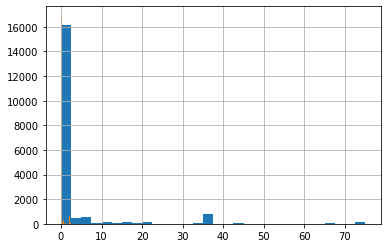

In [109]:
qa1 = bz.loc[bz.subregion == 4]
print(qa1.name.unique())
qa1.max_dua.hist(bins=30)

<AxesSubplot:>

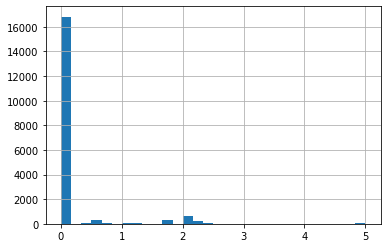

In [108]:
qa1.max_far.hist(bins=30)

In [106]:
# number of parcels with DUA > 25
len(rural_qa.loc[rural_qa.max_dua > 25].parcel_id.unique())

854

In [107]:
rural_qa.loc[rural_qa.max_dua > 25].name.value_counts()

East Contra Costa     590
Napa Remainder        149
SE Snta Clara Cnty    137
Northern Marin         92
Southern Sonoma        68
Solano Remainder       48
Northern Sonoma        31
Name: name, dtype: int64

<AxesSubplot:>

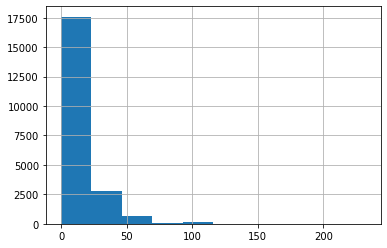

In [96]:
suburban_qa = bz.loc[bz.subregion == 3]
suburban_qa.max_dua.hist(bins=10)

<AxesSubplot:>

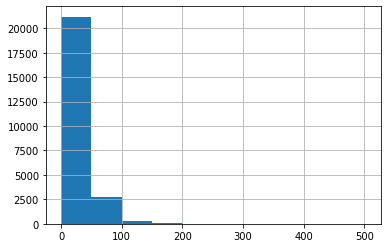

In [97]:
suburban_urban_qa = bz.loc[bz.subregion == 2]
suburban_urban_qa.max_dua.hist(bins=10)

<AxesSubplot:>

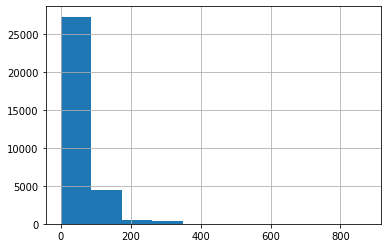

In [98]:
urban_qa = bz.loc[bz.subregion == 1]
urban_qa.max_dua.hist(bins=10)

Zoning Inputs Check: Import latest zoning files to check for outliers

In [11]:
# latest parcels zoning file
pz = pd.read_csv("M:/urban_modeling/baus/BAUS Inputs/basis_inputs/zoning/zoning_parcels_2024-04-30.csv")
# latest parcel lookup file
zl = pd.read_csv("M:/urban_modeling/baus/BAUS Inputs/basis_inputs/zoning/zoning_lookup_2024-04-30.csv")

# merge the zoning lookup to parcels
pz = pz.merge(zl, left_on='zoning_id', right_on='id', how='left')

1. Add a superdistrict variable to categorize parcels by place type

In [44]:
pz = pz.merge(ptaz[['PARCEL_ID', 'ZONE_ID']], on='PARCEL_ID', how='left')\
              .merge(taz[['zone', 'superdistrict']], left_on='ZONE_ID', right_on='zone', how='left')\
              .merge(sd, left_on='superdistrict', right_on='number')